In [13]:
import pandas as pd
import numpy as np
import string
import os
import re, string
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, concatenate, Activation, LSTM, Bidirectional
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#/content/drive/MyDrive/Ordenar/DSRP/df.xlsx
mainpath = '/content/drive/MyDrive/Ordenar/DSRP/'
filename = 'train.xlsx'
fullpath = os.path.join(mainpath, 'train.xlsx')
train=pd.read_excel(fullpath, usecols=['Comentario','Clasificación'])

fullpath = os.path.join(mainpath, 'test.xlsx')
test=pd.read_excel(fullpath, usecols=['Comentario','Clasificación'])

In [4]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import regexp_tokenize   # module for tokenizing strings
from nltk.tokenize import TreebankWordTokenizer

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*¿!¡?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
train['Comentario'] = train['Comentario'].apply(lambda x: clean_text(x))
test['Comentario']= test['Comentario'].apply(lambda x: clean_text(x))

In [7]:
!pip install nltk

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
train.shape, test.shape

((15728, 2), (3932, 2))

In [11]:
#print('Loading data...')
#train = pd.read_csv(r"train.csv")
#test = pd.read_csv(r"test.csv")
#test_labels = pd.read_csv(r"test_labels.csv")

#test = pd.concat([test, test_labels], axis=1)
#test = test[test['toxic']!=-1]

classes = ["Clasificación"]
y_train = train[classes].values
y_test = test[classes].values

train_sentences = train["Comentario"].fillna("fillna")
test_sentences = test["Comentario"].fillna("fillna")

In [12]:
!pip install transformers

     |████████████████████████████████| 2.5MB 13.4MB/s 
     |████████████████████████████████| 901kB 51.2MB/s 
     |████████████████████████████████| 3.3MB 56.2MB/s 


In [15]:
#%%
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import *
import transformers
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Accuracy
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, average_precision_score, recall_score, precision_score, matthews_corrcoef, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score
#%%

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
padded_ids_train = []
mask_ids_train = []

for i in tqdm(range(len(train_sentences))):
    encoding = tokenizer.encode_plus(train_sentences[i], max_length=128, pad_to_max_length=True, do_lower_case= False)
    input_ids, attention_id = encoding["input_ids"], encoding["attention_mask"]
    padded_ids_train.append(input_ids)
    mask_ids_train.append(attention_id)

padded_ids_test = []
mask_ids_test = []

for i in tqdm(range(len(test_sentences))):
    encoding=tokenizer.encode_plus(test_sentences[i], max_length=128, pad_to_max_length=True, do_lower_case= False)
    input_ids, attention_id = encoding["input_ids"], encoding["attention_mask"]
    padded_ids_test.append(input_ids)
    mask_ids_test.append(attention_id)

train_id = np.array(padded_ids_train)
train_mask = np.array(mask_ids_train)
test_id = np.array(padded_ids_test)
test_mask = np.array(mask_ids_test)

#%%

input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)
input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
md  = model([input_1 , input_2] , training = False )
x = tf.reshape(md.pooler_output , (-1 , md.pooler_output.shape[1]))
x = tf.keras.layers.Dense(128 , activation= tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Dense(1 , activation = tf.nn.sigmoid)(x)
model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [x])
model.summary()

path= "modelo4.h5"
checkpoint = ModelCheckpoint(filepath=path, monitor='val_precision', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model.compile(optimizer=Adam(lr=3e-5),loss=tf.keras.losses.binary_crossentropy, metrics=tf.keras.metrics.Precision())

# Training model...
history = model.fit([train_id,train_mask], y_train, batch_size=4, epochs=10, callbacks=checkpoint, validation_split=0.1)

# Loading model...
model.load_weights('modelo4.h5')
y_pred = model.predict([test_id, test_mask])

  0%|          | 0/15728 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2111: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'do_lower_case': False} not recognized.


Se han truncado las últimas 5000 líneas del flujo de salida.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
 93%|█████████▎| 14677/15728 [00:54<00:04, 217.10it/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3539/3539 [==============================] - 385s 103ms/step - loss: 0.1930 - precision: 0.9205 - val_loss: 0.1749 - val_precision: 0.9144

Epoch 00001: val_precision improved from -inf to 0.91442, saving model to modelo4.h5
Epoch 2/10
3539/3539 [==============================] - 355s 100ms/step - loss: 0.1394 - precision: 0.9398 - val_loss: 0.2207 - val_precision: 0.8950

Epoch 00002: val_precision did not improve from 0.91442
Epoch 3/10
3539/3539 [==============================] - 358s 101ms/step - loss: 0.1112 - precision: 0.9618 - val_loss: 0.2319 - val_precision: 0.9310

Epoch 00003: val_precision improved from 0.91442 to 0.93103, saving model to modelo4.h5
Epoch 4/10
3539/3539 [==============================] - 359s 101ms/step - loss: 0.0862 - precision: 0.9726 - val_loss: 0.2196 - val_precision: 0.9325

Epoch 00004: val_precision improved from 0.93103 to 0.93253, saving model to modelo4.h5
Epoch 5/10
3539/3539 [==============================] - 358s 101ms/step - loss: 0.0821 - p

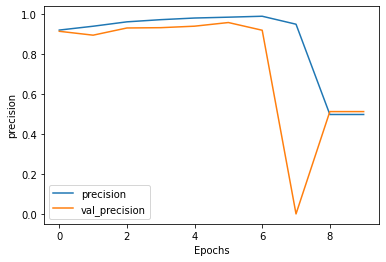

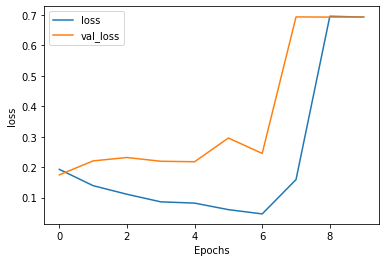

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "precision")
plot_graphs(history, "loss")

In [17]:
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1

In [19]:
print('Classification report {}'.format(classification_report(y_test, y_int, zero_division=0)))
print('Confusion matrix {}'.format(multilabel_confusion_matrix(y_test, y_int)))
print('accuracy {}'.format(accuracy_score(y_test,y_int)))
print('precisision {}'.format(precision_score(y_test,y_int)))
print('Roc-auc score is {}'.format(roc_auc_score(y_test, y_pred)))

Classification report               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1966
           1       0.95      0.92      0.94      1966

    accuracy                           0.94      3932
   macro avg       0.94      0.94      0.94      3932
weighted avg       0.94      0.94      0.94      3932

Confusion matrix [[[1807  159]
  [  86 1880]]

 [[1880   86]
  [ 159 1807]]]
accuracy 0.9376907426246185
precisision 0.9545694664553619
Roc-auc score is 0.9671022333898037


In [ ]:
# Guardar el Modelo
#model.save('modelo4.h5')

In [ ]:
#model.save(path) 
 
#new_model = keras.models.load_model('modelo4.h5') 
 
# Recrea exactamente el mismo modelo 
#new_model = keras.experimental.load_from_saved_model('modelo4.h5')

In [44]:
mainpath = '/content/drive/MyDrive/Ordenar/DSRP/'
filename = 'validacion.xlsx'
fullpath = os.path.join(mainpath, filename)
validacion=pd.read_excel(fullpath)

In [45]:
validacion.head()

,Comentario,Relevancia,Clasificacion
0,"3D Bones and organos, Bacteria interactiva y ...",No Considerar,0
1,.BUENAS TARDES FE Y ALEGRIA Nª70 PRESENTE,No Considerar,0
2,:buffering:Buenas tardes compañeros Jorstin Sa...,No Considerar,0
3,Abraham Juarez Silva Director I.E. Monte Lima ...,No Considerar,0
4,AlainJhon Reyes Leon del colegio 32645 de CARA...,No Considerar,0


In [46]:
validacion = validacion.iloc[:480 ,:]

In [ ]:
validacion.shape

In [48]:
validacion['Comentario'] = validacion['Comentario'].apply(lambda x: clean_text(x))

Validación

In [49]:
validacion_sentences = validacion["Comentario"].fillna("fillna")

In [50]:
padded_ids_validacion = []
mask_ids_validacion = []

In [51]:
for i in tqdm(range(len(validacion_sentences))):
    encoding=tokenizer.encode_plus(validacion_sentences[i], max_length=128, pad_to_max_length=True, do_lower_case= False)
    input_ids, attention_id = encoding["input_ids"], encoding["attention_mask"]
    padded_ids_validacion.append(input_ids)
    mask_ids_validacion.append(attention_id)

  0%|          | 0/480 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2111: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'do_lower_case': False} not recognized.
Keyword arguments {'d

In [52]:
validacion_id = np.array(padded_ids_validacion)
validacion_mask = np.array(mask_ids_validacion)

In [53]:
y_pred_validacion = model.predict([validacion_id, validacion_mask])

In [54]:
y_int_validacion = np.zeros_like(y_pred_validacion)
y_int_validacion[y_pred_validacion > 0.5] = 1

In [55]:
classesv = ["Clasificacion"]
y_validacion = validacion[classesv].values

In [56]:
print('Classification report {}'.format(classification_report(y_validacion, y_int_validacion, zero_division=0)))
print('Confusion matrix {}'.format(multilabel_confusion_matrix(y_validacion, y_int_validacion)))
print('accuracy {}'.format(accuracy_score(y_validacion,y_int_validacion)))
print('precisision {}'.format(precision_score(y_validacion,y_int_validacion)))
print('Roc-auc score is {}'.format(roc_auc_score(y_validacion, y_int_validacion)))

Classification report               precision    recall  f1-score   support

           0       0.97      0.97      0.97       367
           1       0.90      0.91      0.90       113

    accuracy                           0.95       480
   macro avg       0.93      0.94      0.94       480
weighted avg       0.95      0.95      0.95       480

Confusion matrix [[[103  10]
  [ 12 355]]

 [[355  12]
  [ 10 103]]]
accuracy 0.9541666666666667
precisision 0.8956521739130435
Roc-auc score is 0.9394034385474186


In [57]:
#validacion['clasificacion_pred'] = validacion_pred.tolist()
validacion['clasificacion_pred_int'] = y_int_validacion.tolist()

In [58]:
validacion.head()

,Comentario,Relevancia,Clasificacion,clasificacion_pred_int
0,bones and organos bacteria interactiva y xmind,No Considerar,0,[1.0]
1,buenas tardes fe y alegria presente,No Considerar,0,[0.0]
2,bufferingbuenas tardes compañeros jorstin samp...,No Considerar,0,[0.0]
3,abraham juarez silva director ie monte lima i...,No Considerar,0,[0.0]
4,alainjhon reyes leon del colegio de carampayo...,No Considerar,0,[0.0]


In [59]:
validacion.to_excel('Prueba4.xlsx',index=False)